# Program Analysis Seedling Kickoff Demo

*University of Arizona*

*July 26, 2018*


In this demo we will show how a dynamic Bayes network (DBN) can be constructed from the source code for a FORTRAN program. This notebook has been tested with the version of Delphi corresponding to the commit hash shown below.

In [1]:
!git rev-parse HEAD

97e2191be081642e1de27be659e4dbe900cc9aca


Some preliminaries:

In [2]:
%load_ext autoreload
%autoreload 2
import sys
import json
from importlib import import_module
from IPython.core.display import Image
import delphi.jupyter_tools as jt
from delphi.program_analysis.scopes import Scope
from delphi.program_analysis.ProgramAnalysisGraph import ProgramAnalysisGraph
from delphi.bmi import initialize, update

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import numpy as np

We start with the FORTRAN program, `crop_yield.f` shown below.

In [3]:
jt.display(f'../data/program_analysis/crop_yield.f')

## Analyze the FORTRAN source code

The FORTRAN program is now analyzed by the autoTranslate 
program analysis pipeline:
- Analyze the FORTRAN source to produce an XML representation of the abstract
    syntax tree (AST)
- Translate the AST into a functionally equivalent Python source file
- Extract component assignment functions (lambda functions) and variable functional relationships within scope (DBN-JSON).

In [4]:
%cd ../delphi/program_analysis/autoTranslate/
!./autoTranslate ../../../data/program_analysis/crop_yield.f
%cd ../../../notebooks/

/Users/adarsh/ml4ai/delphi/delphi/program_analysis/autoTranslate
+ java fortran.ofp.FrontEnd --class fortran.ofp.XMLPrinter --verbosity 0 ../../../data/program_analysis/crop_yield.f
+ python scripts/translate.py -f crop_yield.xml -g crop_yield.py
+ python scripts/genPGM.py -f crop_yield.py -p pgm.json -l lambdas.py
/Users/adarsh/ml4ai/delphi/notebooks


This generates several files.  First, program analysis autoTranslate analyses the FORTRAN code to extract the AST (abstract syntax tree), represented in xml:

In [5]:
jt.display('../delphi/program_analysis/autoTranslate/crop_yield.xml')

A functionally equivalent Python source file is generated (preserving semantics of the FORTRAN source, such as call by reference):

In [6]:
jt.display('../delphi/program_analysis/autoTranslate/crop_yield.py')

Variable assignment functions are extracted into an interface of modular executable functions, or 'lambdas'.

In [7]:
jt.display('../delphi/program_analysis/autoTranslate/lambdas.py')

The Python source is then parsed into a JSON representation of the 
statements and functions contained in the program. 

In [8]:
dbn_json = '../delphi/program_analysis/autoTranslate/pgm.json'
jt.display(dbn_json)

## Assemble the DBN

Delphi takes this JSON description, discovers all scopes and assignment 
statements in it, and builds a graph that shows how 
information flows through the program during runtime.

### Constructing the scope tree

The scope tree is a rooted collection of nested `Scope` objects.
We currently have two different types of scopes that our program identifies:

- A `LoopScope` meant to track loops found in the initial program 
- A `ContainerScope` meant to track functions found in the initial program.

The `scope_tree` defined below will be a `Scope` object that has other `Scope` objects as its children.
### Viewing the DBN

The final step is to construct a DBN from `scope_tree`. 
Below we create a digraph to show the DBN as a flow of information through 
the program at runtime. Scopes are nested and the breadth of each scope 
is shown with a colored bounding box. Function scopes are colored in green 
while loop scopes are shown in blue. Each scope is labeled with the scope 
specific name as found in the JSON specification. Variables from the program 
are shown as ellipses contained in their appropriate scopes. Variables are 
 with the name of the variable in the program and the name of the 
scope in which the variable was first defined. Actions, such as variable 
assignment or conditional evaluation, are shown as black rectangles and are 
labeled similarly to variables.

This graph has a linked structure that shows how variables from one scope 
populate for use into child scopes. This allows us to see the entire data 
flow profile of the initial program at runtime.

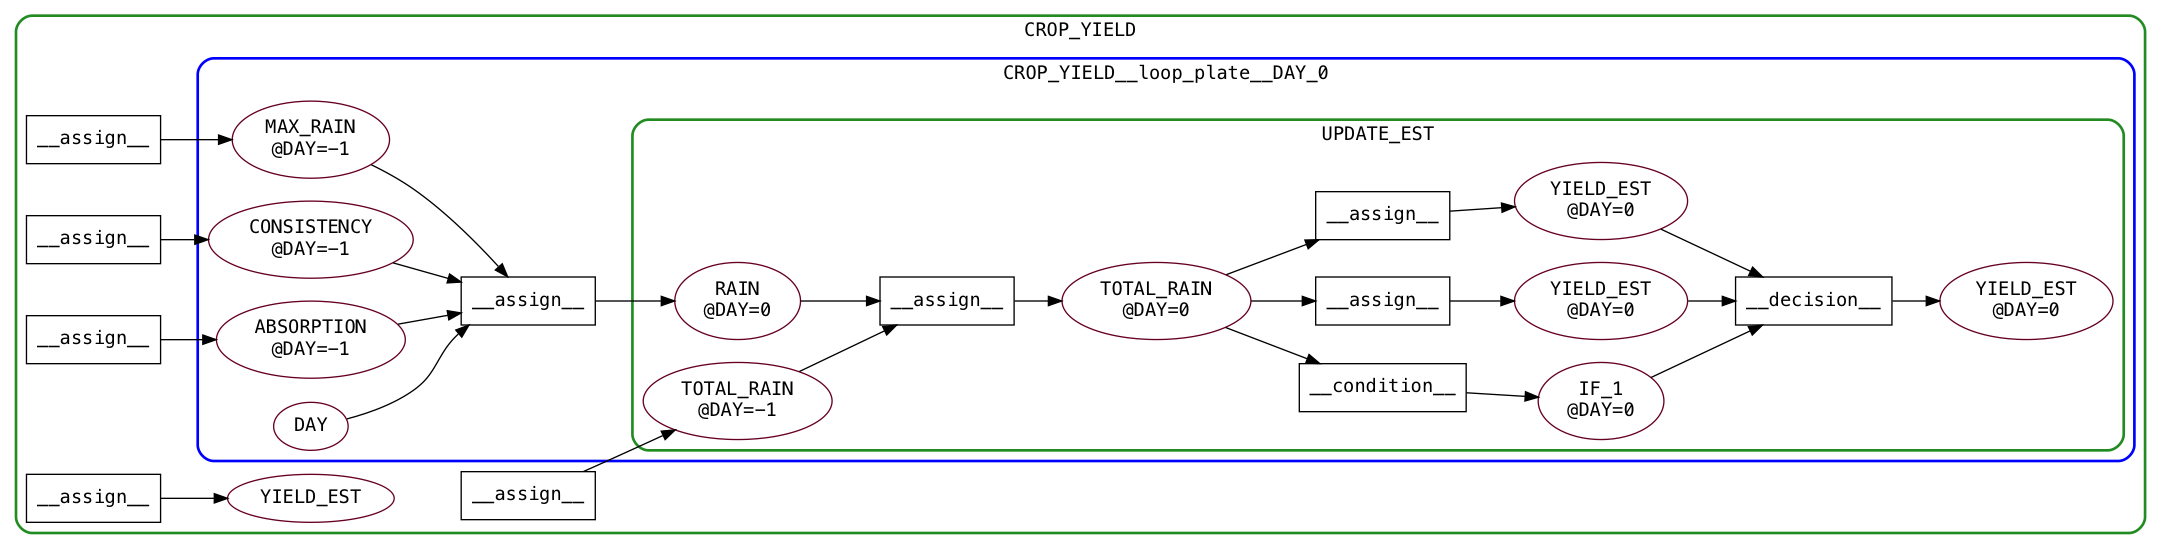

In [9]:
root = Scope.from_json('../delphi/program_analysis/autoTranslate/pgm.json')
A = root.to_agraph()
Image(A.draw(format='png', prog='dot'), retina=True)

## Executing the DBN

With the DBN now assembled and represented within Delphi, we can execute the DBN, displayed here from a CAG view of the DBN with variable states updating as the loop is unfolded.

In [10]:
sys.path.append('../delphi/program_analysis/autoTranslate')
import lambdas
G = ProgramAnalysisGraph.from_agraph(A, lambdas)

We first initialize the variables whose assignment doesn't depend on 
other variables.

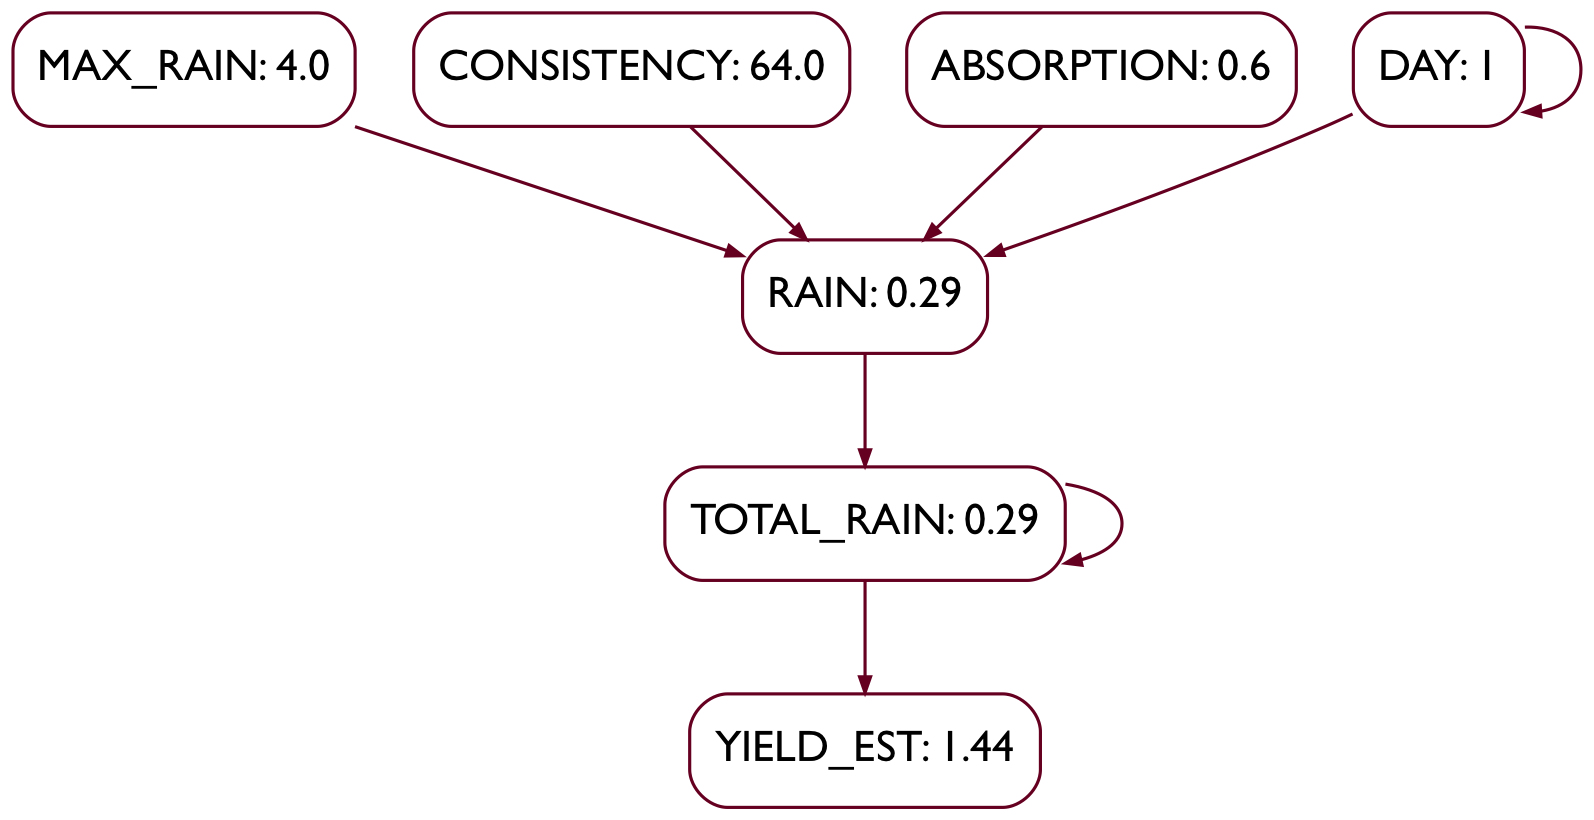

In [11]:
from delphi.visualization import visualize
initialize(G)
visualize(G, show_values=True)

We then update the CAG, visiting each node and updating it
based on the function associated with that node and the predecessors of
the node. This update is performed recursively - if the update function requires
the value of an predecessor node that has not been computed yet, then that
predecessor node's update function is called in turn, and so on.

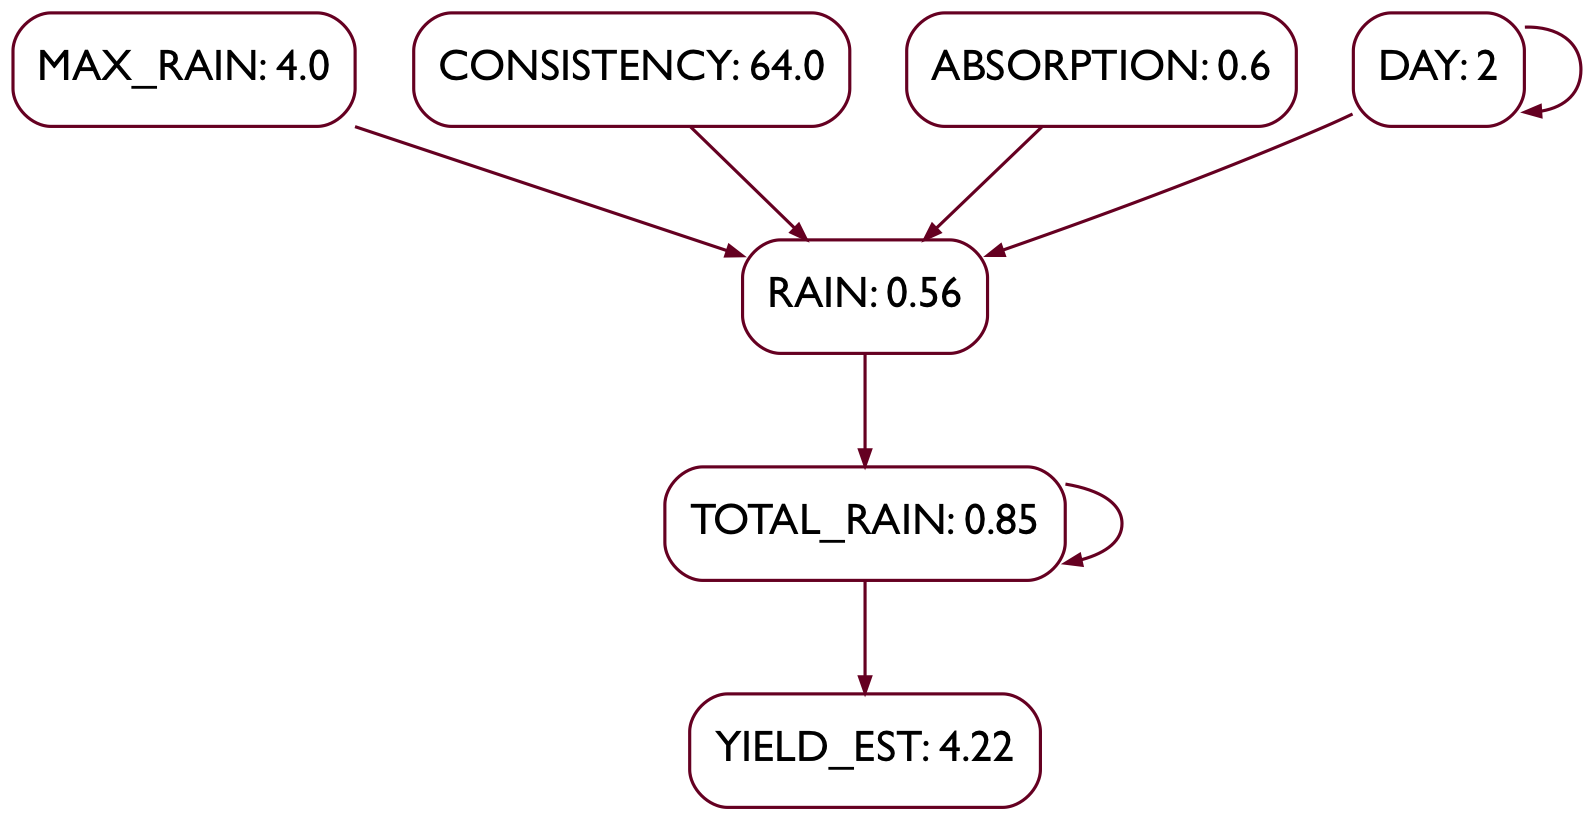

In [12]:
update(G)
visualize(G, show_values=True)

Upon performing another update, we can see the values of the nodes changing.

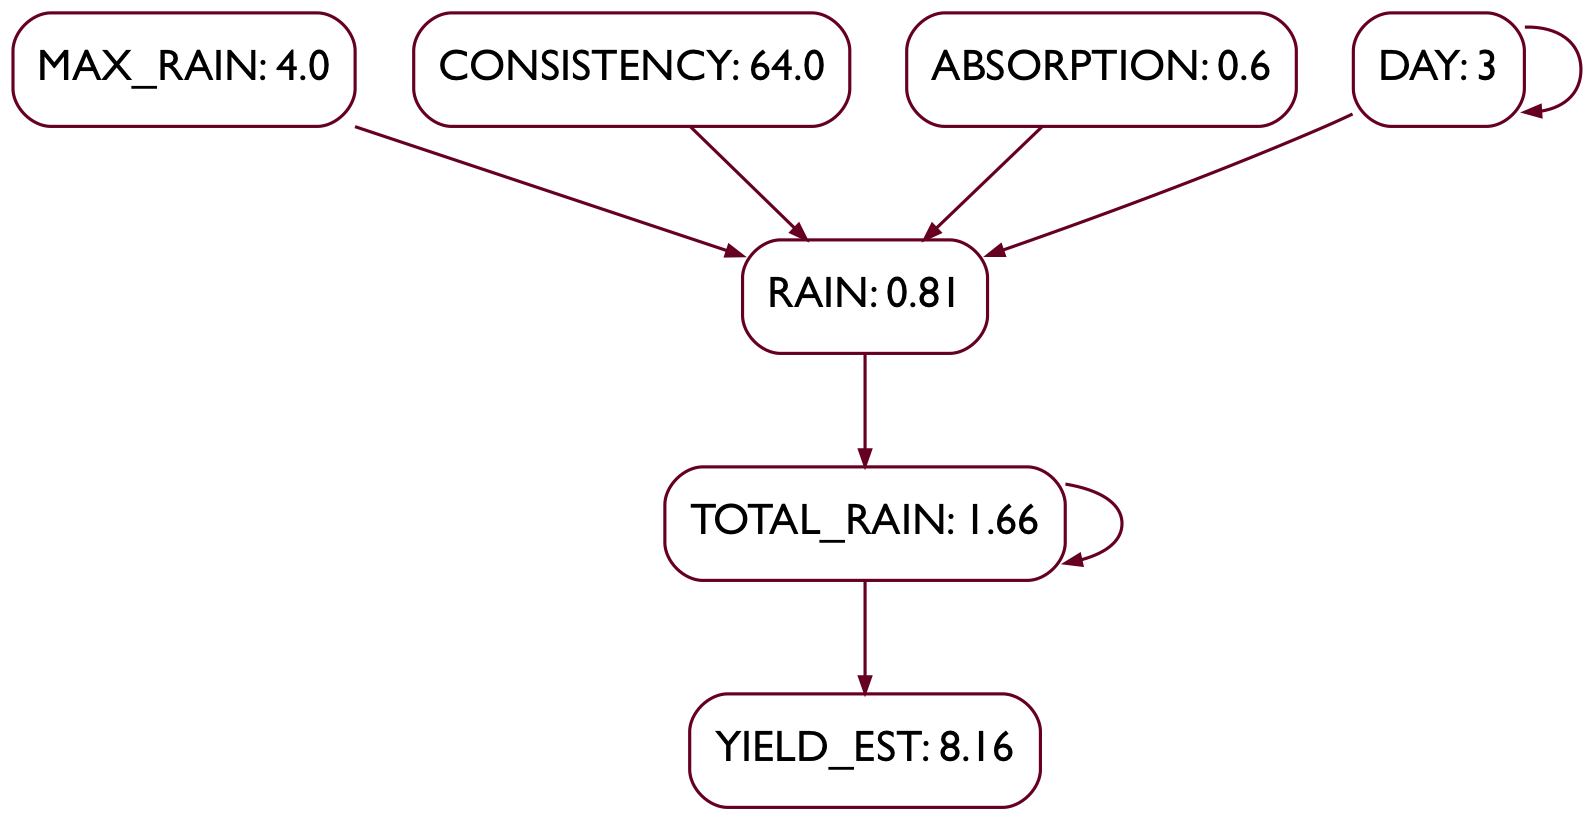

In [13]:
update(G)
visualize(G, show_values=True)

The values of the variables are identical to the ones output by the original FORTRAN program.

In the plots below we demonstrate some of the potential for sensitivity
analysis using this framework. In the input cell below we define a function
for plotting three variables of interest: `RAIN`, `TOTAL_RAIN`, and `YIELD_EST`,
as a function of `DAY`. 

In addition, we provide an option to go 'non-deterministic', i.e. we say that
instead of `MAX_RAIN` being constant at 4, we assert `MAX_RAIN`$\sim \mathcal{N}(4,1)$.

In [14]:
def make_plots(n_samples, deterministic = True):
    variables = ('RAIN', 'TOTAL_RAIN', 'YIELD_EST')
    vals = {k:[] for k in variables}
    days = {k:[] for k in variables}
    palette = sns.color_palette()
    colors = {k:palette[i] for i, k in enumerate(vals)}
    fig, axes = plt.subplots(1,len(vals), figsize=(12, 3))
    ax = {k:axes[i] for i, k in enumerate(vals)}
    
    for _ in range(n_samples):
        G = ProgramAnalysisGraph.from_agraph(A, lambdas)
        if not deterministic:
            G.nodes['MAX_RAIN']['init_fn'] = lambda: np.random.normal(4, 1)             
        initialize(G)
        for i in range(1,31):
            update(G)
            for k in vals:
                vals[k].append(G.nodes[k]['value'])
                days[k].append(G.nodes['DAY']['value']-2)

    for k in vals:
        sns.lineplot(days[k], vals[k], ax = ax[k], label=k, color=colors[k])
        ax[k].set_xlabel('DAY')
        ax[k].set_ylabel(k)

    plt.tight_layout()


First, we show the results of running the program deterministically.

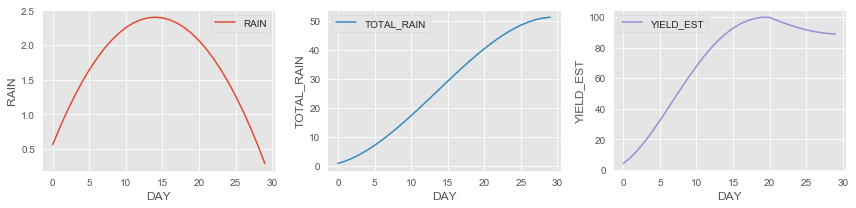

In [15]:
make_plots(1)

Note the inflection point of `YIELD_EST` that occurs when `TOTAL_RAIN` = 40: this is the basis of the conditional expression in the original FORTRAN code.

If we turn off the deterministic behaviour, we get the following results, with 
the uncertainty in the outputs caused by the stochasticity in the input `MAX_RAIN`.

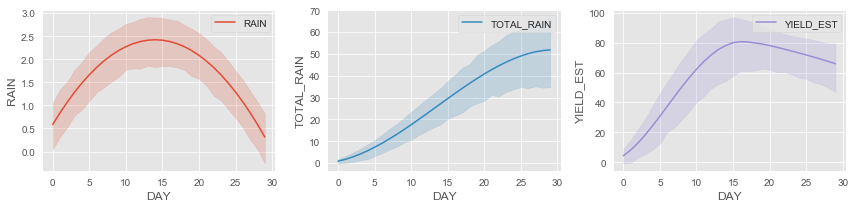

In [16]:
make_plots(10, deterministic=False)

## Summary

With Delphi, we can go from FORTRAN source code to a dynamic Bayes net. The 
internal representation of Delphi has been made flexible enough to accommodate
custom update functions which can come a variety of sources:

- Domain experts
- Natural language processing and gradable adjective quantifications
- Program analysis.